# Milestone P4 :

### Through this project we propose new figures and analysis to the "Predicting present with Google Trends paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_absolute_error


## Q1 : Does the model improve the prediction over the base model for the initial claims data ?

In [2]:
# Load iclaims Data :
data_iclaims = pd.read_csv('merged_iclaims.csv')
# Reshape of the DataFrame into a more convenient form :
data_iclaims.Index = pd.to_datetime(data_iclaims.Index)
# Relevant turning points for analysis :
idx1 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-03-07'])].index.tolist()[0] 
idx2 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-05-02'])].index.tolist()[0]
idx3 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-12-05'])].index.tolist()[0]
idx4 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-02-06'])].index.tolist()[0]
idx5 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-07-10'])].index.tolist()[0]
idx6 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-07-17'])].index.tolist()[0]
idx7 = data_iclaims.loc[data_iclaims['Index'].isin(['2011-01-01'])].index.tolist()[0]
idx8 = data_iclaims.loc[data_iclaims['Index'].isin(['2011-05-07'])].index.tolist()[0]

data_iclaims = data_iclaims.set_index(data_iclaims['Index'])
data_iclaims.index = pd.DatetimeIndex(data_iclaims.index.values,freq='W-SAT') # Indicate that our index is sampled by weeks
data_iclaims.rename(columns = {'claims.sa':'claims_sa'}, inplace = True)
data_iclaims.rename(columns = {'claims.nsa':'claims_nsa'}, inplace = True)
data_iclaims.rename(columns = {'Welfare...Unemployment':'WelfareUnemployment'}, inplace = True)

# Data preprocessing :
data_iclaims['claims_sa']= np.log(data_iclaims['claims_sa'])
data_iclaims['claims_nsa']= np.log(data_iclaims['claims_nsa'])
data_iclaims['s1sa']=data_iclaims['claims_sa'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims
data_iclaims.head()

,Index,claims_sa,claims_nsa,Jobs,WelfareUnemployment,s1sa
2004-01-10,2004-01-10,12.777052,13.426751,6.066862,-7.574152,0.000000
2004-01-17,2004-01-17,12.799399,13.103717,-3.558773,-25.237886,12.777052
2004-01-24,2004-01-24,12.774223,12.853862,-6.184409,-17.401619,12.799399
2004-01-31,2004-01-31,12.837344,12.914842,-7.935044,-18.815352,12.774223
2004-02-07,2004-02-07,12.847927,12.979033,-13.310680,-24.104085,12.837344


### Model without rolling window

For this model, we create a model that forecast initial unemployments claims. We use a simple linear regression with seasonal terms for the Baseline model and Google Trends for the Trends model. We first try to replicate the two Anova tables from the paper to make sure that our model is consistent. Then we plot a new figure close to the one that we already replicated (Figure 2), but using the iclaims predictions this time.

### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [3]:
mod = smf.ols(formula = 'claims_sa ~ s1sa', data= data_iclaims[1:] )
res = mod.fit()
Predictions = res.predict()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              claims_sa   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     9480.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          9.22e-275
Time:                        14:49:26   Log-Likelihood:                 669.17
No. Observations:                 390   AIC:                            -1334.
Df Residuals:                     388   BIC:                            -1326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2549      0.130      1.968      0.0

### Trends model :

We use the seasonnal term $y_{t-1}$ and the Google Trends "Jobs", "Welfare & Unemployment".

In [4]:
# Trends Model :
mod_trends = smf.ols(formula = 'claims_sa ~ s1sa + Jobs + WelfareUnemployment', data= data_iclaims[1:] )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()
print(res_trends.summary())

                            OLS Regression Results                            
Dep. Variable:              claims_sa   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3261.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          9.62e-274
Time:                        14:49:28   Log-Likelihood:                 676.05
No. Observations:                 390   AIC:                            -1344.
Df Residuals:                     386   BIC:                            -1328.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0563    

### MAEs :

According to the tables in the paper, we should start forecasting on the 17th of January 2004 (idx = 1) and end on the 2nd of July 2011 (idx = 391). We evaluate the MAEs at the given turning points in the paper. However, our dataset is constructed such that we cannot predict the exact same dates. Thus, our goal is to approximate the given turning points by close enough time intervals available in our dataset. Some differences in the forecasting improvement between Base and Trend model are expected. 

In [5]:
mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions)/(data_iclaims.claims_sa[1:].mean())
mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions_trends)/(data_iclaims.claims_sa[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

mae_base_turningpoint = mean_absolute_error(data_iclaims.claims_sa[idx1:idx2],Predictions[idx1-1:idx2-1])/(data_iclaims.claims_sa[idx1:idx2].mean())
mae_trends_turningpoint = mean_absolute_error(data_iclaims.claims_sa[idx1:idx2],Predictions_trends[idx1-1:idx2-1])/(data_iclaims.claims_sa[idx1:idx2].mean())
improvement_turningpoint = (mae_base_turningpoint-mae_trends_turningpoint)/mae_base_turningpoint*100

mae_base_turningpoint_2 = mean_absolute_error(data_iclaims.claims_sa[idx3:idx4],Predictions[idx3-1:idx4-1])/(data_iclaims.claims_sa[idx3:idx4].mean())
mae_trends_turningpoint_2 = mean_absolute_error(data_iclaims.claims_sa[idx3:idx4],Predictions_trends[idx3-1:idx4-1])/(data_iclaims.claims_sa[idx3:idx4].mean())
improvement_turningpoint_2 = (mae_base_turningpoint_2-mae_trends_turningpoint_2)/mae_base_turningpoint_2*100

mae_base_turningpoint_3 = np.abs(data_iclaims.claims_sa[idx6]-Predictions[idx6-1])/(data_iclaims.claims_sa[idx6])
mae_trends_turningpoint_3 = np.abs(data_iclaims.claims_sa[idx6]-Predictions_trends[idx6-1])/(data_iclaims.claims_sa[idx6])
improvement_turningpoint_3 = (mae_base_turningpoint_3-mae_trends_turningpoint_3)/mae_base_turningpoint_3*100

mae_base_turningpoint_4 = mean_absolute_error(data_iclaims.claims_sa[idx7:idx8],Predictions[idx7-1:idx8-1])/(data_iclaims.claims_sa[idx7:idx8].mean())
mae_trends_turningpoint_4 = mean_absolute_error(data_iclaims.claims_sa[idx7:idx8],Predictions_trends[idx7-1:idx8-1])/(data_iclaims.claims_sa[idx7:idx8].mean())
improvement_turningpoint_4 = (mae_base_turningpoint_4-mae_trends_turningpoint_4)/mae_base_turningpoint_4*100

In [6]:
print('MAE Trends Overall =',mae_trends_overall)
print('MAE Base Overall =',mae_base_overall)
print('MAE Trends Over turningpoint =',mae_trends_turningpoint)
print('MAE Base Over turningpoint =',mae_base_turningpoint)
print('MAE Trends Over turningpoint 2 =',mae_trends_turningpoint_2)
print('MAE Base Over turningpoint 2 =',mae_base_turningpoint_2)
print('MAE Trends Over turningpoint 3 =',mae_trends_turningpoint_3)
print('MAE Base Over turningpoint 3 =',mae_base_turningpoint_3)
print('MAE Trends Over turningpoint 4 =',mae_trends_turningpoint_4)
print('MAE Base Over turningpoint 4 =',mae_base_turningpoint_4)

MAE Trends Overall = 0.0025382631579881727
MAE Base Overall = 0.002551898503544962
MAE Trends Over turningpoint = 0.0022459473763192777
MAE Base Over turningpoint = 0.0022363563719774216
MAE Trends Over turningpoint 2 = 0.002298104150105915
MAE Base Over turningpoint 2 = 0.0027227896803713168
MAE Trends Over turningpoint 3 = 0.0022385778181538136
MAE Base Over turningpoint 3 = 0.004561682535186772
MAE Trends Over turningpoint 4 = 0.003921505688008188
MAE Base Over turningpoint 4 = 0.003968190434459541


### Plots :

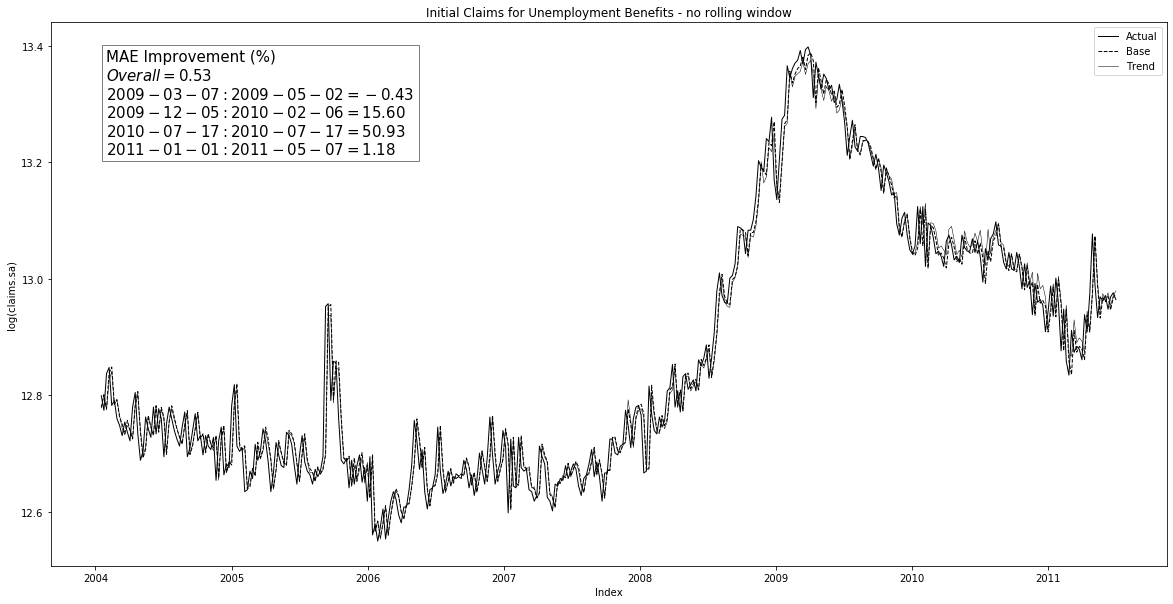

In [8]:
#Plots :
fig,ax = plt.subplots()
ax.plot(data_iclaims['Index'][1:],data_iclaims['claims_sa'][1:],color='black',label='Actual',linewidth=1)
ax.plot(data_iclaims['Index'][1:],Predictions,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(data_iclaims['Index'][1:],Predictions_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,),
    r'$2009-03-07: 2009-05-02=%.2f$'%(improvement_turningpoint,),
    r'$2009-12-05 : 2010-02-06=%.2f$'%(improvement_turningpoint_2,),
    r'$2010-07-17 : 2010-07-17=%.2f$'%(improvement_turningpoint_3,),
    r'$2011-01-01 : 2011-05-07=%.2f$'%(improvement_turningpoint_4,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits - no rolling window')
fig.set_size_inches(20,10)
plt.show()

## Q2 :Is the model consistent with other topics and/or other time series ?

we try to forecast the same dataset (initial claims) but for another time series (2011 to 2020)

In [9]:
# Load The datasets
trends = pd.read_csv('multiTimeline.csv')
claims = pd.read_csv('ICSA.csv')
print(trends.head(2))
print(' ')
print(claims.head(1))
print(' ')

# Reshape trends in a more convenient form :
trends = trends.reset_index()
trends.rename(columns = {'level_0':'DATE'}, inplace = True)
trends.rename(columns = {'level_1':'Jobs'}, inplace = True)
trends.rename(columns = {'Catégorie\xa0: Toutes catégories':'Unemployment'}, inplace = True)
trends = trends.drop([0])
print(trends.head(1))
print(' ')

# claims has weekly observations of iclaims and trends has monthly observations.
# To solve this issue, we calculate the monthly average for iclaims. We already select the time frame of interest
# 2011-2020
idx = trends.loc[trends['DATE'].isin(['2011-01'])].index.tolist()[0] 
months = trends['DATE'][idx-1:]
ICSA = []
for i in months:
    icsa = claims[[i in name for name in claims['DATE']]].mean()
    ICSA.append(icsa[0])
    
# Finally we create a clean dataframe with all the required features
iclaims = pd.DataFrame({'DATE':trends['DATE'][idx-1:],'Jobs':trends['Jobs'][idx-1:],'Unemployment':trends['Unemployment'][idx-1:],'ICSA':ICSA }).reset_index().drop('index', axis=1)
iclaims.DATE = pd.to_datetime(iclaims.DATE)
iclaims = iclaims.set_index(iclaims['DATE'])
iclaims.index = pd.DatetimeIndex(iclaims.index.values,freq='MS') # Indicate that our index is sampled by months
iclaims.head(3)

                           Catégorie : Toutes catégories
Mois    Jobs: (États-Unis)    Unemployment: (États-Unis)
2004-01 52                                             5
 
         DATE    ICSA
0  1967-01-07  208000
 
      DATE Jobs Unemployment
1  2004-01   52            5
 


,DATE,Jobs,Unemployment,ICSA
2011-01-01,2011-01-01,66,15,426800.0
2011-02-01,2011-02-01,60,13,401500.0
2011-03-01,2011-03-01,61,11,406000.0


### Preprocessing :

In [10]:
# Data preprocessing :
iclaims['ICSA']= np.log(iclaims['ICSA'])
iclaims['s1']=iclaims['ICSA'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims
iclaims.head()

,DATE,Jobs,Unemployment,ICSA,s1
2011-01-01,2011-01-01,66,15,12.964071,0.000000
2011-02-01,2011-02-01,60,13,12.902963,12.964071
2011-03-01,2011-03-01,61,11,12.914108,12.902963
2011-04-01,2011-04-01,59,11,12.949438,12.914108
2011-05-01,2011-05-01,63,11,12.953945,12.949438


### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [11]:
mod = smf.ols(formula = 'ICSA ~ s1', data= iclaims[1:] )
res = mod.fit()
Predictions = res.predict()

### Trends model :

We use the seasonnal term $y_{t-1}$ and the Google Trends "Jobs", "Welfare & Unemployment".

In [12]:
# Trends Model :
mod_trends = smf.ols(formula = 'ICSA ~ s1 + Jobs + Unemployment', data=iclaims[1:] )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()

### MAEs :

We evaluate the overall MAEs, as we don't know the turning points. Finding turning points will be one goal of the figure analysis.

In [13]:
mae_base_overall = mean_absolute_error(iclaims.ICSA[1:],Predictions)/(iclaims.ICSA[1:].mean())
mae_trends_overall = mean_absolute_error(iclaims.ICSA[1:],Predictions_trends)/(iclaims.ICSA[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

In [14]:
print('MAE Trends Overall =',mae_trends_overall)
print('MAE Base Overall =',mae_base_overall)

MAE Trends Overall = 0.0014664015572445534
MAE Base Overall = 0.005773215377098246


### Plots :

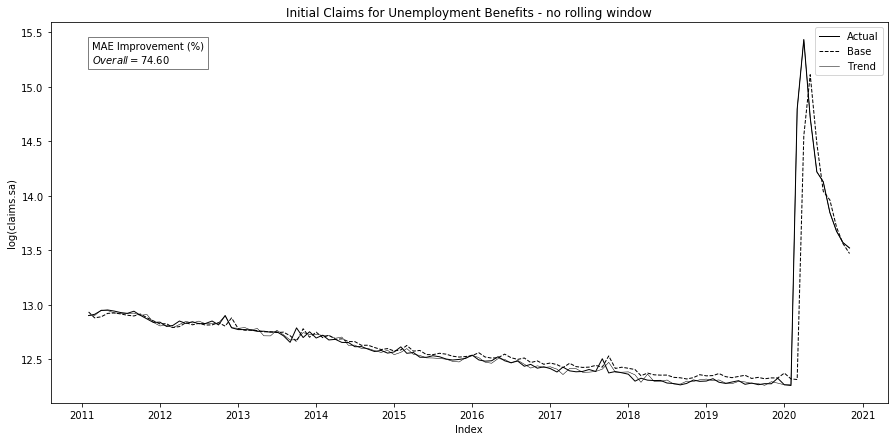

In [15]:
#Plots :
fig,ax = plt.subplots()
ax.plot(iclaims['DATE'][1:],iclaims['ICSA'][1:],color='black',label='Actual',linewidth=1)
ax.plot(iclaims['DATE'][1:],Predictions,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(iclaims['DATE'][1:],Predictions_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits - no rolling window')
fig.set_size_inches(15,7)
plt.show()